In [985]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorflow import keras

from dataset_CELTIC import CELTICDataGen
from models.MaskGenerator_CELTIC import MaskGenerator
from models.UNETO_CELTIC import UNet3D
from models.fnet_model import CELTICModel
from transforms import normalize, normalize_with_mask, Propper


In [986]:
class CELTICWrapper(nn.Module):
    def __init__(self, celtic_model):
        super().__init__()
        self.model = celtic_model
        self.model.net.eval()
        for param in self.model.net.parameters():
            param.requires_grad = False  # Freeze weights

    def forward(self, signal: torch.Tensor, context: torch.Tensor = None, m = None):
        # Assumes signal is (1, C, D, H, W), context is (1, F)
        # with torch.no_grad():
        #     if context is not None:
        #         return self.model.net(signal, context)
        #     else:
        #         return self.model.net(signal)

        if context is not None:
            pred = self.model.net(signal, context)
            pred = pred * m
        else:
            pred = self.model.net(signal)
            pred = pred * m
        return pred


In [987]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules"]

In [ ]:
# Define base path for all operations
BASE_PATH = f'/{"/".join(os.getcwd().split("/")[1:-1])}'
RESOURCES_PATH = BASE_PATH + "/resources/resources"
print(BASE_PATH)
print(RESOURCES_PATH)

In [1063]:
# --- Configuration ---
weighted_pcc = False
signals_are_masked = True
organelle = all_organelles[1]
organelle_path = organelle.lower()

unet_model_path = f"{RESOURCES_PATH}/{organelle}/models/best_model_context.p"
mg_model_path = f"{BASE_PATH}/mg/{organelle}/model_mw_0.9_lr_1e-05_pcc_0.89_noise_1.0.pt"
data_path = f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/"
test_csv_path = f"{RESOURCES_PATH}/{organelle}/metadata/test_images.csv"
test_context_path = f"{RESOURCES_PATH}/{organelle}/metadata/test_context.csv"
patch_size = (32, 64, 64, 1)


In [1064]:
# --- Load context config ---
with open(f"{RESOURCES_PATH}/{organelle}/models/context_model_config.json", 'r') as file:
    context_model_config = json.load(file)

In [1065]:
transforms_config = context_model_config["transforms"]

# Evaluate each string in the config using `eval`, injecting train_patch_size
transforms = {
    k: eval(v, {"normalize": normalize,
                "normalize_with_mask": normalize_with_mask,
                "Propper": Propper,
                "train_patch_size": patch_size[:-1]})
    for k, v in transforms_config.items()
}

In [1066]:
# === Load Datasets ===
test_dataset = CELTICDataGen(test_csv_path, data_path, test_context_path, transforms, signals_are_masked)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [1067]:
context_features = context_model_config['context_features']
daft_embedding_factor = context_model_config['daft_embedding_factor']
daft_scale_activation = context_model_config['daft_scale_activation']

context_df = pd.read_csv(test_context_path)
context = {
    'context_features': context_features,
    'context_features_len': context_df.shape[1],
    'daft_embedding_factor': daft_embedding_factor,
    'daft_scale_activation': daft_scale_activation
}


In [1068]:
# === Initialize Models ===
unet = UNet3D(in_channels=2, out_channels=1)


In [1069]:
%%capture

# --- Load CELTIC model ---
celtic_model = CELTICModel(context=context, signals_are_masked=signals_are_masked)
celtic_model.load_state(unet_model_path)
celtic_wrapper = CELTICWrapper(celtic_model)

celtic_model.net.eval()

# --- Load Mask model ---
mg = MaskGenerator(patch_size, unet, celtic_wrapper, mask_loss_weight=0.7, weighted_pcc=weighted_pcc,
                   pcc_target=0.92)
mg.load_state_dict(torch.load(mg_model_path))

mg.eval()


In [1070]:
%%capture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
celtic_model.net.to(device)
mg.to(device)

In [1170]:
# To get a specific row in the dataset
row_number = 659

# Get images
(x, context), y, m = test_dataset[row_number]

# Add batch size and make torch
x = torch.from_numpy(np.expand_dims(x, axis=0))
context = torch.from_numpy(np.expand_dims(context, axis=0))
y = torch.from_numpy(np.expand_dims(y, axis=0))
m = torch.from_numpy(np.expand_dims(m, axis=0))

# Move to device if needed
x, context, y, m = x.to(device), context.to(device), y.to(device), m.to(device)

# Run through the model
with torch.no_grad():
    prediction = celtic_wrapper(x, context, m)


In [1171]:
# # Make an iterator from the DataLoader
# iterator = iter(test_loader)


In [1172]:
# # Get batch
# (x, context), y, m = next(iterator)

# # Move to device if needed
# x, context, y, m = x.to(device), context.to(device), y.to(device), m.to(device)

# # Run through the model
# with torch.no_grad():
#     prediction = celtic_wrapper(x, context, m)


In [1173]:
# x.shape


In [1174]:
# prediction.shape


In [1175]:
with torch.no_grad():
    x_input = torch.cat([
        F.relu(F.conv3d(x, weight=torch.ones(1, x.shape[1], 3, 3, 3).to(device), padding=1)),
        F.relu(F.conv3d(prediction, weight=torch.ones(1, prediction.shape[1], 3, 3, 3).to(device), padding=1))
    ], dim=1).to(device)


In [1176]:
mask = mg.mask_net(x_input)


In [1177]:
mask.shape


torch.Size([1, 1, 32, 224, 256])

In [1178]:
input_patch = x.detach().cpu()
target_patch = y.detach().cpu()
pred = prediction.detach().cpu()
mask_prediction = mask.detach().cpu()


In [1179]:
threshold = 0.4
binary_mask = (mask_prediction > threshold).float()

(-0.5, 255.5, 223.5, -0.5)

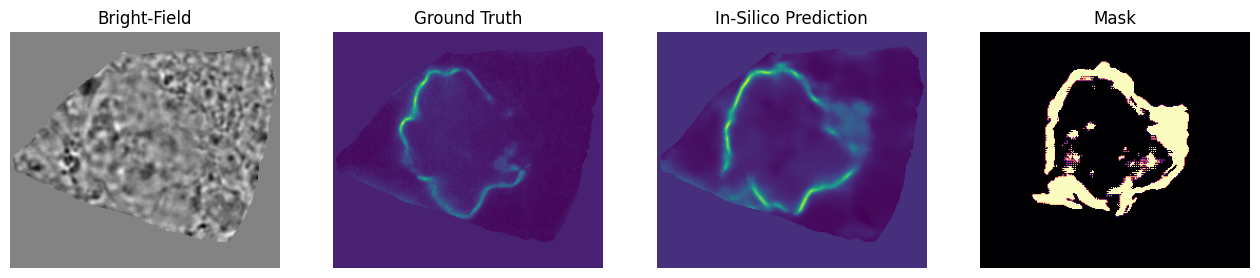

In [1180]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(input_patch[0,0,zs,:,:], cmap='gray')
ax1.set_title('Bright-Field')
ax1.axis('off')
ax2.imshow(target_patch[0,0,zs,:,:], cmap='viridis')
ax2.set_title('Ground Truth')
ax2.axis('off')
ax3.imshow(pred[0,0,zs,:,:], cmap='viridis')
ax3.set_title('In-Silico Prediction')
ax3.axis('off')
ax4.imshow(binary_mask[0,0,zs,:,:], cmap='magma')
ax4.set_title('Mask')
ax4.axis('off')

## Noise Validation

In [976]:
# Add PCC function
from metrics import pearson_corr_torch

In [978]:
# Choose mask threshold
threshold = 0.1
binary_mask = (mask_prediction > threshold).float()

In [979]:
# Lion's pipeline
noise = torch.randn_like(mask_prediction) * 1.0
noised_input = input_patch + (noise * (1-binary_mask) * m.cpu())
noised_input = noised_input.to(device)

(-0.5, 223.5, 223.5, -0.5)

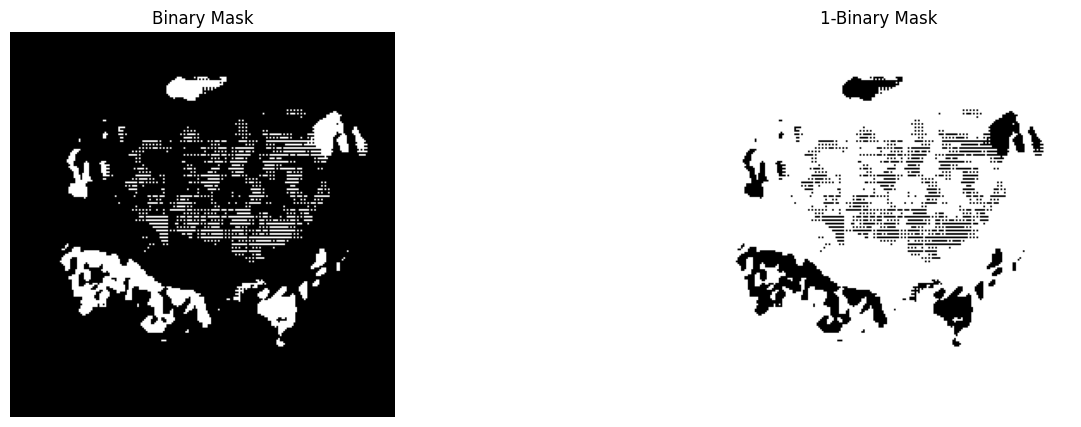

In [980]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(binary_mask[0,0,zs,:,:], cmap='gray')
ax1.set_title('Binary Mask')
ax1.axis('off')
ax2.imshow(1-binary_mask[0,0,zs,:,:], cmap='gray')
ax2.set_title('1-Binary Mask')
ax2.axis('off')

In [981]:
noised_prediction = celtic_wrapper(noised_input, context, m)

In [982]:
noised_input = noised_input.detach().cpu()
noised_prediction = noised_prediction.detach().cpu()

In [983]:
print("PCC after noising: ", round(pearson_corr_torch(noised_prediction, pred).item(), 4))

PCC after noising:  0.5269


(-0.5, 223.5, 223.5, -0.5)

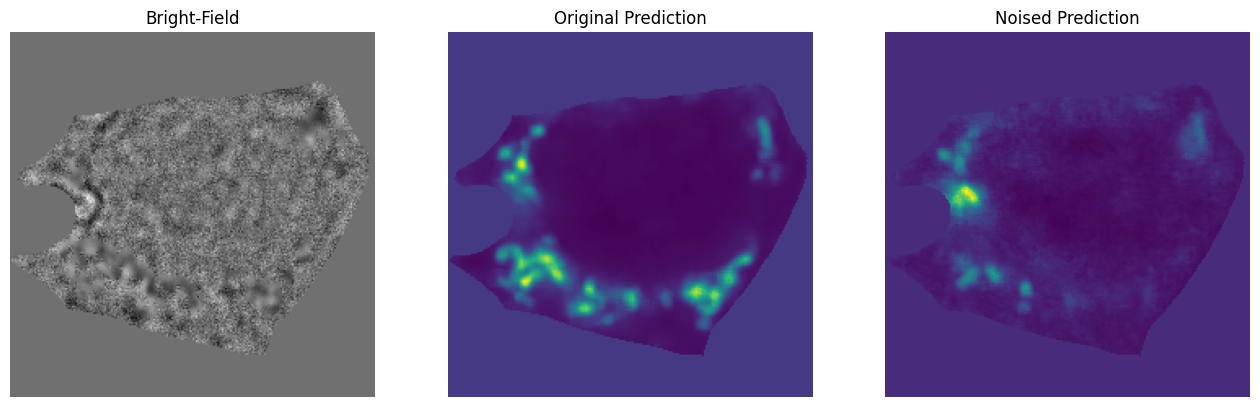

In [984]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(noised_input[0,0,zs,:,:], cmap='gray')
ax1.set_title('Bright-Field')
ax1.axis('off')
ax2.imshow(pred[0,0,zs,:,:], cmap='viridis')
ax2.set_title('Original Prediction')
ax2.axis('off')
ax3.imshow(noised_prediction[0,0,zs,:,:], cmap='viridis')
ax3.set_title('Noised Prediction')
ax3.axis('off')